In [1]:
# python libraries
import os
import sys
import dataclasses
import datetime
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

try:
    import torchsummary
except:
    print(f"[INFO] Installing the torchsummary")
    %pip install torchsummary

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

In [2]:
## Connect Persistence memory
try :
    from google.colab import drive

    # Paths
    DRIVE_PATH = Path("/content/drive")
    MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

    # mount drive
    drive.mount(str(DRIVE_PATH))
except:
    MODEL_SAVE_PATH = Path(os.getcwd())/"models"

# Network in Network

In [3]:
@dataclass(eq=False)
class NiN(helper.Classifier):
    lr:int = 0.01
    num_classes:int = 10

    def __post_init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.nin_block(96,kernel=11,stride=4,padding=0),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(256,kernel=5,stride=1,padding=2),
            nn.MaxPool2d(kernel_size=3,stride=2),
            self.nin_block(384,kernel=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(self.num_classes,kernel=3,stride=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )


    @staticmethod
    def nin_block(out_channels,kernel,stride,padding):
        return nn.Sequential(
            nn.LazyConv2d(out_channels,kernel_size=kernel,stride=stride,padding=padding),nn.ReLU(),
            # this two layer will do job of FC , this will  increase the non linearity.
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU(),
            nn.LazyConv2d(out_channels,kernel_size=1),nn.ReLU()          
        )
    @staticmethod
    def init_nin(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)

In [4]:
NiN().layer_summary((1,1,224,224))

Sequential      output shape :(1, 96, 54, 54)
MaxPool2d       output shape :(1, 96, 26, 26)
Sequential      output shape :(1, 256, 26, 26)
MaxPool2d       output shape :(1, 256, 12, 12)
Sequential      output shape :(1, 384, 12, 12)
MaxPool2d       output shape :(1, 384, 5, 5)
Dropout         output shape :(1, 384, 5, 5)
Sequential      output shape :(1, 10, 5, 5)
AdaptiveAvgPool2d output shape :(1, 10, 1, 1)
Flatten         output shape :(1, 10)


c:\Users\Lenovo\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
torchsummary.summary(NiN(),input_size=(1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          11,712
              ReLU-2           [-1, 96, 54, 54]               0
            Conv2d-3           [-1, 96, 54, 54]           9,312
              ReLU-4           [-1, 96, 54, 54]               0
            Conv2d-5           [-1, 96, 54, 54]           9,312
              ReLU-6           [-1, 96, 54, 54]               0
         MaxPool2d-7           [-1, 96, 26, 26]               0
            Conv2d-8          [-1, 256, 26, 26]         614,656
              ReLU-9          [-1, 256, 26, 26]               0
           Conv2d-10          [-1, 256, 26, 26]          65,792
             ReLU-11          [-1, 256, 26, 26]               0
           Conv2d-12          [-1, 256, 26, 26]          65,792
             ReLU-13          [-1, 256, 26, 26]               0
        MaxPool2d-14          [-1, 256,

The total parameter size is reduce compare to pervious architecture like AlexNet ,VGG , since they had the FC layer 

# Training

In [6]:
model = NiN(lr=0.01)
data = helper.FashionMNIST(batch_size=128,resize=(224,224))
model.apply_init([(next(iter(data.train_dataloader())))[0]],model.init_nin)

Training the model in cpu


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

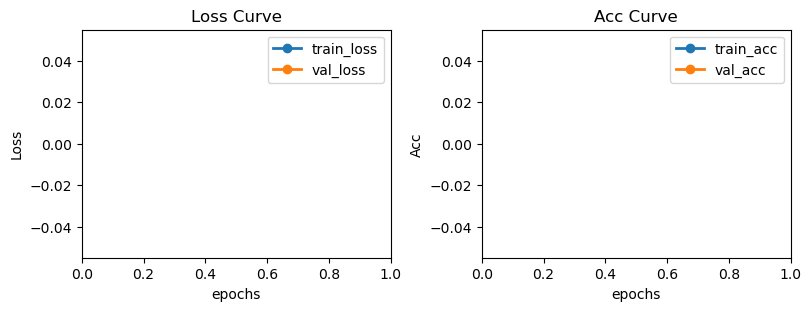

In [7]:
trainer =helper.Trainer(max_epochs=10,model_save_path=MODEL_SAVE_PATH)
trainer.fit(model,data)